In [1]:

'''This example demonstrates the use of fasttext for text classification
Based on Joulin et al's paper:
Bags of Tricks for Efficient Text Classification
https://arxiv.org/abs/1607.01759
Results on IMDB datasets with uni and bi-gram embeddings:
    Uni-gram: 0.8813 test accuracy after 5 epochs. 8s/epoch on i7 cpu.
    Bi-gram : 0.9056 test accuracy after 5 epochs. 2s/epoch on GTx 980M gpu.
'''

from __future__ import print_function
import numpy as np
import sys
sys.path.append('datasets')

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D

import codeforces

def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337], [1, 3, 7, 9, 2, 1337, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for i in range(len(new_list) - ngram_range + 1):
            for ngram_value in range(2, ngram_range + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 3
top_words = 500
max_len = 10000
batch_size = 64
embed_dim = 32
dropout = 0.2
epochs = 20

print('Loading data...')
(x_train, y_train), (x_test, y_test) = codeforces.load_data(num_words=top_words)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = top_words + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    top_words = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(top_words,
                    embed_dim,
                    input_length=max_len))
model.add(Dropout(dropout))
model.add(Conv1D(padding="same", kernel_size=3,activation='relu',filters=64))
# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Using TensorFlow backend.


Loading data...
11586 train sequences
11586 test sequences
Average train sequence length: 462
Average test sequence length: 450
Adding 3-gram features
Average train sequence length: 1383
Average test sequence length: 1340
Pad sequences (samples x time)
x_train shape: (11586, 10000)
x_test shape: (11586, 10000)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10000, 32)         5104544   
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10000, 64)         6208      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dens

In [2]:
#评估模型好坏
#precision = TP / (TP + FP)
#recall = TP / (TP + FN)
#accuracy = (TP + TN) / (TP + FP + TN + FN)
#F1 Score = 2*P*R/(P+R)，其中P和R分别为 precision 和 recall
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
y_preds = np.round(model.predict(x_test))
result = precision_recall_fscore_support(y_test, y_preds, average='binary')
print(result)

(0.74184566428003185, 0.78958509737510585, 0.76497128794093516, None)


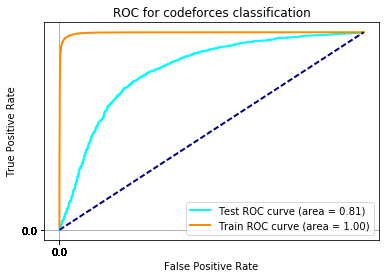

In [5]:
#ROC曲线和AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr={}
tpr={}
roc_auc={}

y_score1 = model.predict(x_test)
y_score2 = model.predict(x_train)

fpr['test'], tpr['test'], _ = roc_curve(y_test, y_score1)
roc_auc['test'] = auc(fpr['test'], tpr['test'])
fpr['train'], tpr['train'], _ = roc_curve(y_train, y_score2)
roc_auc['train'] = auc(fpr['train'], tpr['train'])
    
plt.figure()
lw = 2
tick_nb = 20

ticks = [x/tick_nb for x in range(1, tick_nb)]
labels = ['%.1f'%tick if tick*10%1==0 else '' for tick in ticks]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.plot(fpr['test'], tpr['test'], color='aqua',
         lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc['test'])
plt.plot(fpr['train'], tpr['train'], color='darkorange',
         lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc['train'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for codeforces classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()